# PDE 3D

In [1]:
# the key is randomness of scale_base_noise, and G

In [3]:
from kan import KAN, LBFGS
import torch
#from torch.autograd import grad
import matplotlib.pyplot as plt
from torch import autograd
from tqdm import tqdm

dim = 3
np_i = 11
np_b = 11
ranges = [-1, 1]

model = KAN(width=[3,3,3,1], grid=5, k=3, grid_eps=1.0, noise_scale_base=2.0)

def batch_jacobian(func, x, create_graph=False):
    # x in shape (Batch, Length)
    def _func_sum(x):
        return func(x).sum(dim=0)
    return autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1,0,2)

# define solution
sol_fun = lambda x: torch.sin(torch.pi*x[:,[0]])*torch.sin(torch.pi*x[:,[1]])*torch.sin(torch.pi*x[:,[2]])
source_fun = lambda x: -3*torch.pi**2 * torch.sin(torch.pi*x[:,[0]])*torch.sin(torch.pi*x[:,[1]])*torch.sin(torch.pi*x[:,[2]])

# interior
x_mesh = torch.linspace(ranges[0],ranges[1],steps=np_i)
y_mesh = torch.linspace(ranges[0],ranges[1],steps=np_i)
z_mesh = torch.linspace(ranges[0],ranges[1],steps=np_i)
X, Y, Z = torch.meshgrid(x_mesh, y_mesh, z_mesh, indexing="ij")
x_i = torch.stack([X.reshape(-1,), Y.reshape(-1,), Z.reshape(-1,)]).permute(1,0)

# boundary, 6 sides
helper = lambda X, Y, Z: torch.stack([X.reshape(-1,), Y.reshape(-1,), Z.reshape(-1,)]).permute(1,0)
xb1 = helper(X[0], Y[0], Z[0])
xb2 = helper(X[-1], Y[0], Z[0])
xb3 = helper(X[:,0], Y[:,0], Z[:,0])
xb4 = helper(X[:,0], Y[:,-1], Z[:,0])
xb5 = helper(X[:,:,0], Y[:,:,0], Z[:,:,0])
xb6 = helper(X[:,:,0], Y[:,:,0], Z[:,:,-1])
x_b = torch.cat([xb1, xb2, xb3, xb4, xb5, xb6], dim=0)

steps = 10
alpha = 0.01
log = 1

def train():
    optimizer = LBFGS(model.parameters(), lr=1, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)
    pbar = tqdm(range(steps), desc='description')
    for _ in pbar:
        def closure():
            optimizer.zero_grad()
            # interior loss
            sol = sol_fun(x_i)
            sol_D1_fun = lambda x: batch_jacobian(model, x, create_graph=True)[:,0,:]
            sol_D1 = sol_D1_fun(x_i)
            sol_D2 = batch_jacobian(sol_D1_fun, x_i, create_graph=True)[:,:,:]
            lap = torch.sum(torch.diagonal(sol_D2, dim1=1, dim2=2), dim=1, keepdim=True)
            source = source_fun(x_i)
            pde_loss = torch.mean((lap - source)**2)

            # boundary loss
            bc_true = sol_fun(x_b)
            bc_pred = model(x_b)
            bc_loss = torch.mean((bc_pred-bc_true)**2)

            loss = alpha * pde_loss + bc_loss
            #exec(code)
            loss.backward()
            return loss

        if _ % 5 == 0 and _ < 20:
            model.update_grid_from_samples(x_i)

        # interior loss
        sol = sol_fun(x_i)
        sol_D1_fun = lambda x: batch_jacobian(model, x, create_graph=True)[:,0,:]
        sol_D1 = sol_D1_fun(x_i)
        sol_D2 = batch_jacobian(sol_D1_fun, x_i, create_graph=True)[:,:,:]
        lap = torch.sum(torch.diagonal(sol_D2, dim1=1, dim2=2), dim=1, keepdim=True)
        source = source_fun(x_i)
        pde_loss = torch.mean((lap - source)**2)

        # boundary loss
        bc_true = sol_fun(x_b)
        bc_pred = model(x_b)
        bc_loss = torch.mean((bc_pred-bc_true)**2)

        loss = alpha * pde_loss + bc_loss

        l2 = torch.mean((model(x_i) - sol)**2)

        if _ % log == 0:
            pbar.set_description("pde loss: %.2e | bc loss: %.2e | l2: %.2e " % (pde_loss.cpu().detach().numpy(), bc_loss.cpu().detach().numpy(), l2.detach().numpy()))

        optimizer.step(closure)

train()

pde loss: 1.03e+01 | bc loss: 2.22e-02 | l2: 1.70e-02 : 100%|█| 10/10 [01:29<00:


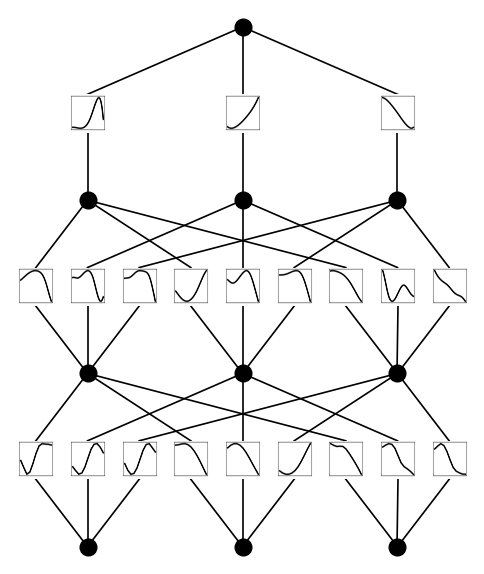

In [4]:
model.plot(beta=100,scale=0.6,sample=False)

In [4]:
for i in range(3):
    for j in range(3):
        model.fix_symbolic(0,i,j,'x')

'''model.fix_symbolic(0,0,0,'sin')
model.fix_symbolic(0,0,1,'sin')'''
        
for i in range(3):
    model.fix_symbolic(1,i,0,'sin')

Best value at boundary.
r2 is 0.8058154313508333
r2 is not very high, please double check if you are choosing the correct symbolic function.
Best value at boundary.
r2 is 0.8194254961416927
r2 is not very high, please double check if you are choosing the correct symbolic function.
Best value at boundary.
r2 is 0.49920824973984773
r2 is not very high, please double check if you are choosing the correct symbolic function.
Best value at boundary.
r2 is 0.772820555743239
r2 is not very high, please double check if you are choosing the correct symbolic function.
Best value at boundary.
r2 is 0.7748374674835091
r2 is not very high, please double check if you are choosing the correct symbolic function.
Best value at boundary.
r2 is 0.781949254036102
r2 is not very high, please double check if you are choosing the correct symbolic function.
Best value at boundary.
r2 is 0.8775439257910191
r2 is not very high, please double check if you are choosing the correct symbolic function.
Best value at 

In [5]:
train()

pde loss: 4.44e+01 | bc loss: 3.27e-02 | l2: 5.07e-02 :  70%|▋| 7/10 [00:39<00:1


KeyboardInterrupt: 

In [19]:
import torch

ranges = [-1,1]
np_i = 11
np_b = 11
# interior
x_mesh = torch.linspace(ranges[0],ranges[1],steps=np_i)
y_mesh = torch.linspace(ranges[0],ranges[1],steps=np_i)
z_mesh = torch.linspace(ranges[0],ranges[1],steps=np_i)
X, Y, Z = torch.meshgrid(x_mesh, y_mesh, z_mesh, indexing="ij")
x_i = torch.stack([X.reshape(-1,), Y.reshape(-1,), Z.reshape(-1,)]).permute(1,0)

helper = lambda X, Y, Z: torch.stack([X.reshape(-1,), Y.reshape(-1,), Z.reshape(-1,)]).permute(1,0)
xb1 = helper(X[0], Y[0], Z[0])
xb2 = helper(X[-1], Y[0], Z[0])
xb3 = helper(X[:,0], Y[:,0], Z[:,0])
xb4 = helper(X[:,0], Y[:,-1], Z[:,0])
xb5 = helper(X[:,:,0], Y[:,:,0], Z[:,:,0])
xb6 = helper(X[:,:,0], Y[:,:,0], Z[:,:,-1])
x_b = torch.cat([xb1, xb2, xb3, xb4, xb5, xb6], dim=0)
x_b

tensor([[-1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.8000],
        [-1.0000, -1.0000, -0.6000],
        ...,
        [ 1.0000,  0.6000,  1.0000],
        [ 1.0000,  0.8000,  1.0000],
        [ 1.0000,  1.0000,  1.0000]])

In [ ]:
optimizer = LBFGS(model.parameters(), lr=1, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

pbar = tqdm(range(steps), desc='description')

alpha = 0.0001

for _ in pbar:
    def closure():
        optimizer.zero_grad()
        # interior loss
        sol = sol_fun(x_i)
        sol_D1_fun = lambda x: batch_jacobian(model, x, create_graph=True)[:,0,:]
        sol_D1 = sol_D1_fun(x_i)
        sol_D2 = batch_jacobian(sol_D1_fun, x_i, create_graph=True)[:,:,:]
        lap = torch.sum(torch.diagonal(sol_D2, dim1=1, dim2=2), dim=1, keepdim=True)
        source = source_fun(x_i)
        pde_loss = torch.mean((lap - source)**2)

        # boundary loss
        bc_true = sol_fun(x_b)
        bc_pred = model(x_b)
        bc_loss = torch.mean((bc_pred-bc_true)**2)

        loss = alpha * pde_loss + bc_loss
        #exec(code)
        loss.backward()
        return loss
    
    #if _ % 5 == 0 and _ < 50:
    #    model.update_grid_from_samples(x_i)
    
    # interior loss
    sol = sol_fun(x_i)
    sol_D1_fun = lambda x: batch_jacobian(model, x, create_graph=True)[:,0,:]
    sol_D1 = sol_D1_fun(x_i)
    sol_D2 = batch_jacobian(sol_D1_fun, x_i, create_graph=True)[:,:,:]
    lap = torch.sum(torch.diagonal(sol_D2, dim1=1, dim2=2), dim=1, keepdim=True)
    source = source_fun(x_i)
    pde_loss = torch.mean((lap - source)**2)

    # boundary loss
    bc_true = sol_fun(x_b)
    bc_pred = model(x_b)
    bc_loss = torch.mean((bc_pred-bc_true)**2)

    loss = alpha * pde_loss + bc_loss
    
    l2 = torch.mean((model(x_i) - sol)**2)
    
    if _ % log == 0:
        pbar.set_description("pde loss: %.2e | bc loss: %.2e | l2: %.2e " % (pde_loss.cpu().detach().numpy(), bc_loss.cpu().detach().numpy(), l2.detach().numpy()))
    
    optimizer.step(closure)

pde loss: 6.87e-01 | bc loss: 1.78e-05 | l2: 2.59e-04 :  10%| | 10/100 [00:10<01

torch.Size([11, 2])

In [165]:
lap.shape

torch.Size([10201, 1])

In [166]:
laplacian = torch.diagonal(sol_D2, dim1=1,dim2=2)

In [141]:
sol_D2.shape

torch.Size([10201, 2, 2])

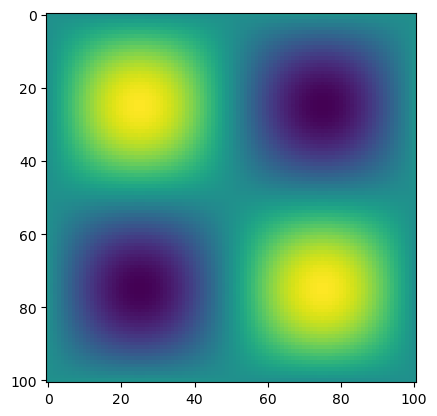

In [127]:
plt.imshow(sol.reshape(n_points, n_points)[:,:].detach().numpy())

In [111]:
x_mesh = torch.linspace(-1,1,steps=n_points)
y_mesh = torch.linspace(-1,1,steps=n_points)
X, Y = torch.meshgrid(x_mesh, y_mesh, indexing="ij")
x_i = torch.stack([X.reshape(-1,), Y.reshape(-1,)]).permute(1,0)
x_i

tensor([[-1.0000, -1.0000],
        [-1.0000, -0.5000],
        [-1.0000,  0.0000],
        [-1.0000,  0.5000],
        [-1.0000,  1.0000],
        [-0.5000, -1.0000],
        [-0.5000, -0.5000],
        [-0.5000,  0.0000],
        [-0.5000,  0.5000],
        [-0.5000,  1.0000],
        [ 0.0000, -1.0000],
        [ 0.0000, -0.5000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.5000],
        [ 0.0000,  1.0000],
        [ 0.5000, -1.0000],
        [ 0.5000, -0.5000],
        [ 0.5000,  0.0000],
        [ 0.5000,  0.5000],
        [ 0.5000,  1.0000],
        [ 1.0000, -1.0000],
        [ 1.0000, -0.5000],
        [ 1.0000,  0.0000],
        [ 1.0000,  0.5000],
        [ 1.0000,  1.0000]])

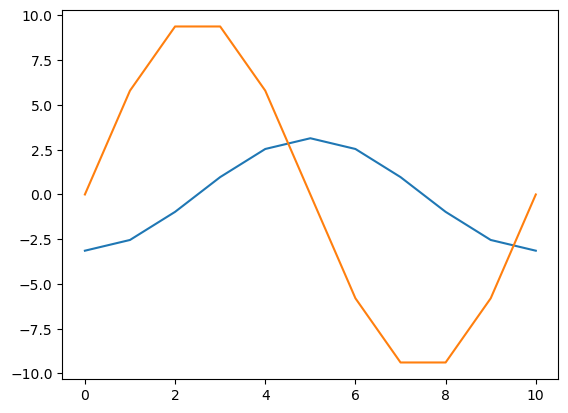

In [86]:
plt.plot(sol_D1[:,0].detach().numpy())
plt.plot(sol_D2[:,0].detach().numpy())

In [87]:
sol_D1**2/torch.pi**2 + sol_D2**2/torch.pi**4

tensor([[1.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000]], grad_fn=<AddBackward0>)

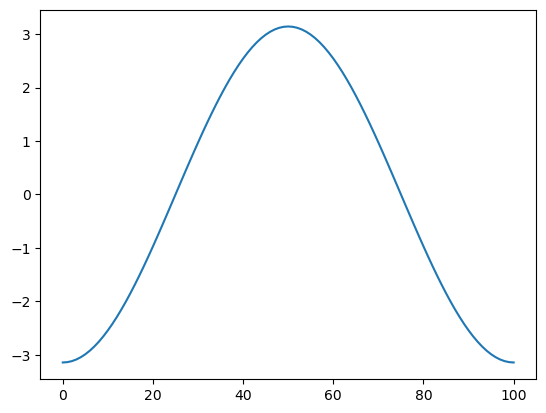

In [38]:

plt.plot(U1[:,0].detach().numpy())

In [23]:
sol = lambda x: torch.sin(torch.pi*x[:,[0]])*torch.sin(torch.pi*x[:,[1]])
x = torch.normal(0,1,size=(100,2))
batch_jacobian(sol, x).shape

torch.Size([100, 1, 2])

In [8]:
from kan import KAN
import torch

# initialize KAN with G=3
model = KAN(width=[2,3,1], grid=5, k=3)

# create dataset
f = lambda x: x[:,[0]]*x[:,[1]] + torch.exp(torch.sin(torch.pi*x[:,[0]])+torch.sin(torch.pi*x[:,[1]]))
dataset = create_dataset(f, n_var=2)